In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from itertools import product

In [3]:
data = pd.read_csv("/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv")
print(data.shape)
data.head()

(372450, 785)


,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
output = data["0"]
Input = data.drop(labels=["0"], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(Input, output, test_size = 0.2, random_state=42, stratify=output)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (297960, 784)
X_test shape: (74490, 784)


In [5]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [6]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

print("x_train shape: " , X_train.shape)
print("x_test shape: " , X_test.shape)

x_train shape:  (297960, 28, 28, 1)
x_test shape:  (74490, 28, 28, 1)


In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [8]:
Y_train = to_categorical(Y_train, num_classes=26)
Y_test = to_categorical(Y_test, num_classes=26)

print(Y_train)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size = 0.15, random_state = 2 , stratify=Y_train.argmax(axis=1))

print("x_train shape",X_train.shape)
print("x_validation shape",X_validation.shape)
print("y_train shape",Y_train.shape)
print("y_validation shape",Y_validation.shape)

x_train shape (253266, 28, 28, 1)
x_validation shape (44694, 28, 28, 1)
y_train shape (253266, 26)
y_validation shape (44694, 26)


In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.12),
    layers.RandomZoom(0.12),
    layers.RandomTranslation(0.12, 0.12),
    layers.RandomContrast(0.12)
], name="data_augmentation")


def preprocess_for_vgg(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.image.grayscale_to_rgb(image)
    return image, label

BATCH = 16

train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_ds = (
    train_ds.shuffle(10000)
            .map(preprocess_for_vgg, num_parallel_calls=tf.data.AUTOTUNE)
            .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH)
            .prefetch(tf.data.AUTOTUNE)
)

val_ds = tf.data.Dataset.from_tensor_slices((X_validation, Y_validation))
val_ds = (
    val_ds.map(preprocess_for_vgg, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(BATCH)
          .prefetch(tf.data.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_ds = (
    test_ds.map(preprocess_for_vgg, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH)
           .prefetch(tf.data.AUTOTUNE)
)

print("Training batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())

I0000 00:00:1764419452.073561      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Training batches: 15830
Validation batches: 2794
Test batches: 4656


In [11]:
l2 = tf.keras.regularizers.l2(1e-4)
model = models.Sequential()

model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2, input_shape=(224,224,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(26, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 512)    │         2,04

 Total params: 46,281,818 (176.55 MB)

 Trainable params: 46,267,738 (176.50 MB)

 Non-trainable params: 14,080 (55.00 KB)

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
]

In [ ]:
epochs = 10
history = model.fit(train_ds, validation_data = val_ds, epochs = epochs, callbacks = callbacks, verbose = 1)

Epoch 1/10


I0000 00:00:1764419488.728800     110 service.cc:148] XLA service 0x7a0ed8002a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764419488.729879     110 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764419491.010982     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


    1/15830 ━━━━━━━━━━━━━━━━━━━━ 145:23:02 33s/step - accuracy: 0.0625 - loss: 5.9996

I0000 00:00:1764419508.243557     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15830/15830 ━━━━━━━━━━━━━━━━━━━━ 3897s 244ms/step - accuracy: 0.7428 - loss: 1.4708 - val_accuracy: 0.9783 - val_loss: 0.4311 - learning_rate: 1.0000e-04
Epoch 2/10
15830/15830 ━━━━━━━━━━━━━━━━━━━━ 3839s 243ms/step - accuracy: 0.9436 - loss: 0.4995 - val_accuracy: 0.9804 - val_loss: 0.2429 - learning_rate: 1.0000e-04
Epoch 3/10
15830/15830 ━━━━━━━━━━━━━━━━━━━━ 3840s 243ms/step - accuracy: 0.9574 - loss: 0.3198 - val_accuracy: 0.9803 - val_loss: 0.2098 - learning_rate: 1.0000e-04
Epoch 4/10
15830/15830 ━━━━━━━━━━━━━━━━━━━━ 3828s 242ms/step - accuracy: 0.9656 - loss: 0.2544 - val_accuracy: 0.9776 - val_loss: 0.2001 - learning_rate: 1.0000e-04
Epoch 5/10
15830/15830 ━━━━━━━━━━━━━━━━━━━━ 3807s 241ms/step - accuracy: 0.9649 - loss: 0.2560 - val_accuracy: 0.9834 - val_loss: 0.1748 - learning_rate: 1.0000e-04
Epoch 6/10
15830/15830 ━━━━━━━━━━━━━━━━━━━━ 3817s 241ms/step - accuracy: 0.9682 - loss: 0.2386 - val_accuracy: 0.9865 - val_loss: 0.1594 - learning_rate: 1.0000e-04
Epoch 7/10
15830/1583

In [16]:
y_prob = model.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)

y_true = np.argmax(np.vstack([y for x, y in test_ds]), axis=1)

4656/4656 ━━━━━━━━━━━━━━━━━━━━ 256s 55ms/step


In [17]:
accuracy = np.mean(y_pred == y_true)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)

Accuracy : 0.9898912605718888
Precision: 0.9864344627520173
Recall   : 0.9878331334365484
F1-score : 0.9871004601117619


In [18]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2774
           1       0.99      0.99      0.99      1734
           2       0.99      0.99      0.99      4682
           3       0.93      0.98      0.95      2027
           4       0.99      0.99      0.99      2288
           5       0.98      0.98      0.98       233
           6       0.99      0.98      0.99      1152
           7       0.98      0.98      0.98      1444
           8       0.98      0.99      0.98       224
           9       0.98      0.98      0.98      1699
          10       0.98      0.99      0.98      1121
          11       0.99      0.98      0.99      2317
          12       0.99      0.99      0.99      2467
          13       0.99      0.98      0.99      3802
          14       0.99      0.99      0.99     11565
          15       1.00      0.99      0.99      3868
          16       0.98      0.98      0.98      1162
          17       0.99    

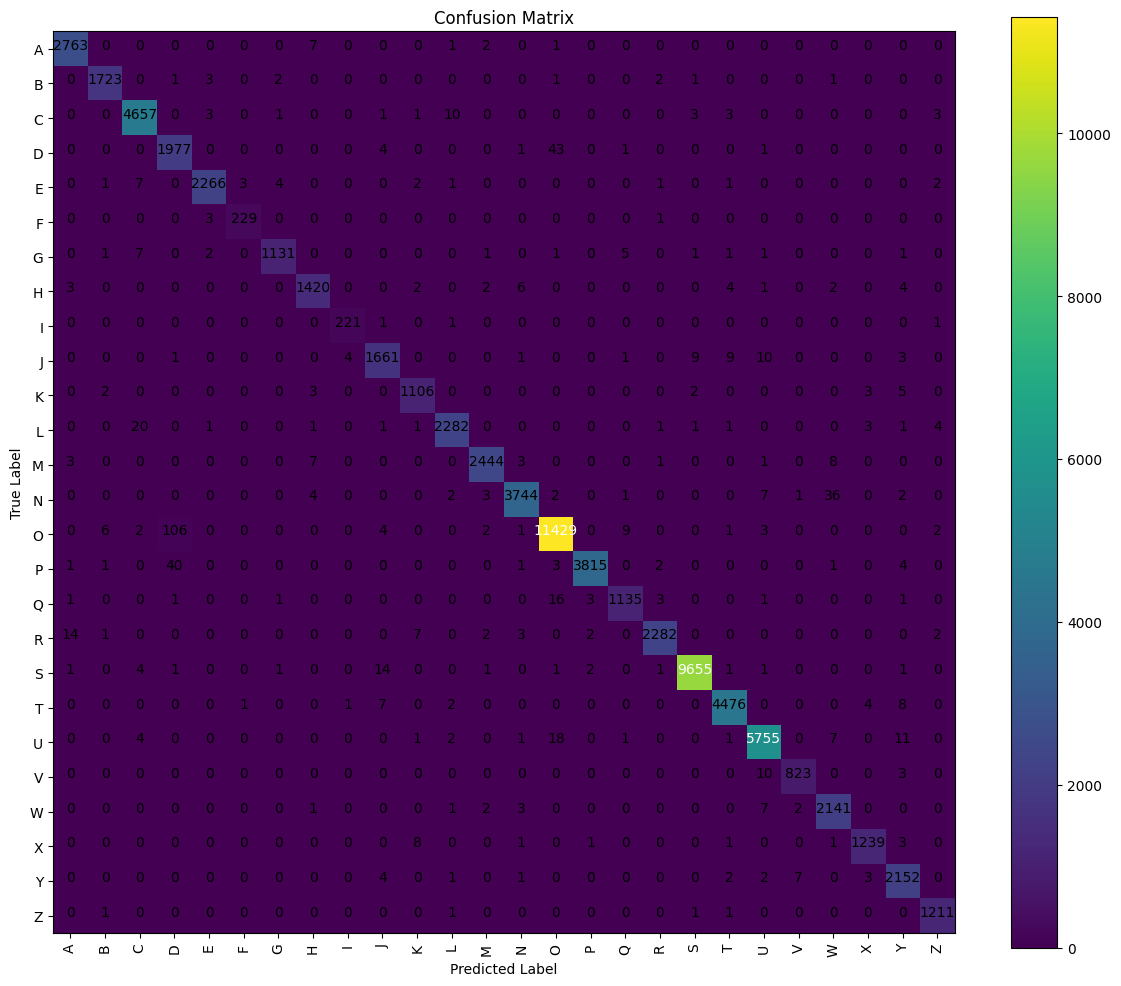

In [19]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()

classes = [chr(i) for i in range(65, 91)]  # A-Z
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2
for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

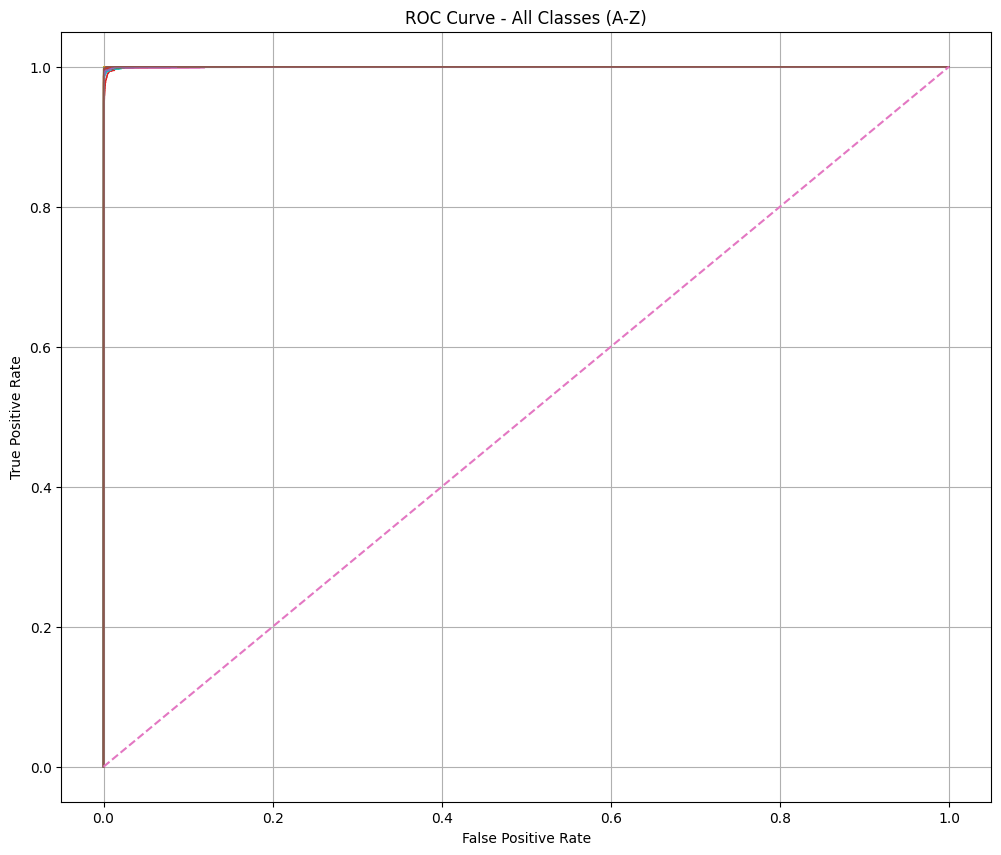

In [20]:
fpr = {}
tpr = {}
roc_auc = {}

y_true_onehot = np.zeros((len(y_true), 26))
for i, label in enumerate(y_true):
    y_true_onehot[i, label] = 1

for i in range(26):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 10))
for i in range(26):
    plt.plot(fpr[i], tpr[i], lw=1)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve - All Classes (A-Z)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()